# Predict TripAdvisor Rating
В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
По ходу задачи:

Прокачаем работу с pandas
Научимся работать с Kaggle Notebooks
Поймем как делать предобработку различных данных
Научимся работать с пропущенными данными (Nan)
Познакомимся с различными видами кодирования признаков
Немного попробуем Feature Engineering (генерировать новые признаки)
И совсем немного затронем ML
И многое другое...

In [113]:
#список используемых библиотек
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 

RANDOM_SEED = 42

In [2]:
# Загружаем данные и переименовываем колонки

df = pd.read_csv('main_task.csv')
df.columns = ['Restaurant_id', 'City', 'CuisineStyle', 'Ranking',
              'Rating', 'PriceRange', 'NumberOfReviews', 'Reviews', 'URL_TA', 'ID_TA']

In [3]:
df.head(10)

,Restaurant_id,City,CuisineStyle,Ranking,Rating,PriceRange,NumberOfReviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Restaurant_id    40000 non-null  object 
 1   City             40000 non-null  object 
 2   CuisineStyle     30717 non-null  object 
 3   Ranking          40000 non-null  float64
 4   Rating           40000 non-null  float64
 5   PriceRange       26114 non-null  object 
 6   NumberOfReviews  37457 non-null  float64
 7   Reviews          40000 non-null  object 
 8   URL_TA           40000 non-null  object 
 9   ID_TA            40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
# Осмотр данных на предмет пропусков

df.nunique(dropna=False)

Restaurant_id      11909
City                  31
CuisineStyle        9008
Ranking            11936
Rating                 9
PriceRange             4
NumberOfReviews     1460
Reviews            33516
URL_TA             39980
ID_TA              39980
dtype: int64

Restaurant_id - список ресторанов. Есть пересечения (рестораны сети). очистка от символов
City - список городов. 31 уникальное значение. Однозначно кодировать
CuisineStyle - список кухонь. есть много пропусков (24%). строка. конвертировать, распарсить. Кодировать.
Ranking - Рейтинг ресторана. Требуется нормировка.
Rating - Итоговый рейтинг. Целевая переменная.
PriceRange - цена ресторана. Перевести в цифровой вид. Есть пропуски (35%). Ставить среднее значение.
NumberOfReviews - Количество отзывов на сайтах. Есть пропуски (7%)
Reviews - 2 отзыва. Требуется ппрсинг. Большое количество нулевых отзывов (17%)
URL_TA - электронные адреса. Можно извлечь данные о сетях ресторанов. Еденичные пересечения.
ID_TA - id ресторанов. Еденичные пересечения.

# Предобработка столбцов

In [6]:
# очистим Restaurant_id оставив только id
df['code_Restaurant_id'] = df['Restaurant_id'].apply(lambda x: float(x[3:]))

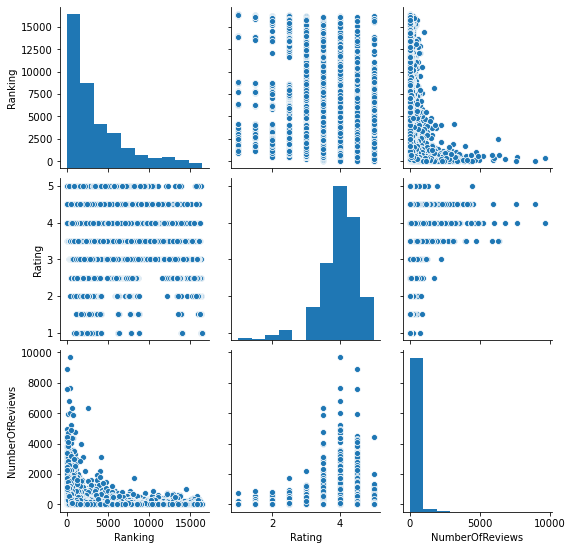

In [7]:
# Посмотрим на распределение численных переменных исходного набора.
# Расперделены по экспоненте, основное сосредоточение возве пиковых (предельных) значений, разброс
sns.pairplot(df.drop(['code_Restaurant_id'], axis=1))

In [8]:
# Посмотрим на распределение городов
df.City.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [9]:
# Сформируем новый признак - страна ресторана

dict_Сountries = {'London': 'England', 'Paris': 'France', 'Madrid': 'Spain',
                  'Barcelona': 'Spain', 'Berlin': 'Germany', 'Milan': 'Italy',
                  'Rome': 'Italy', 'Prague': 'Czech_c', 'Lisbon': 'Portugal',
                  'Vienna': 'Austria', 'Amsterdam': 'Holland',
                  'Brussels': 'Belgium', 'Hamburg': 'Germany', 'Munich': 'Germany',
                  'Lyon': 'France', 'Stockholm': 'Sweden', 'Budapest': 'Romania',
                  'Warsaw': 'Poland', 'Dublin': 'Ireland', 'Copenhagen': 'Denmark',
                  'Athens': 'Greece', 'Edinburgh': 'Scotland', 'Zurich': 'Switzerland',
                  'Oporto': 'Portugal', 'Geneva': 'Switzerland', 'Krakow': 'Poland',
                  'Oslo': 'Norway', 'Helsinki': 'Finland', 'Bratislava': 'Slovakia',
                  'Luxembourg': 'Luxembourg_c', 'Ljubljana': 'Slovenia'}
df['Сountry'] = df.apply(lambda row: dict_Сountries[row['City']], axis=1)

In [10]:
# Создадим признак, означающий, является ли город столицей
is_capital_dict = {
        'Paris': 1,
        'Stockholm': 1,
        'London': 1,
        'Berlin': 1,
        'Munich': 0,
        'Oporto': 0,
        'Milan': 0,
        'Bratislava': 1,
        'Vienna': 1,
        'Rome': 1,
        'Barcelona': 0,
        'Madrid': 1,
        'Dublin': 1,
        'Brussels': 1,
        'Zurich': 0,
        'Warsaw': 1,
        'Budapest': 1,
        'Copenhagen': 1,
        'Amsterdam': 1,
        'Lyon': 0,
        'Hamburg': 0,
        'Lisbon': 1,
        'Prague': 1,
        'Oslo': 1,
        'Helsinki': 1,
        'Edinburgh': 1,
        'Geneva': 0,
        'Ljubljana': 1,
        'Athens': 1,
        'Luxembourg': 1,
        'Krakow': 0
    }

df['Is Capital'] = df['City'].apply(lambda x: is_capital_dict[x])

In [11]:
# Сразу закодируем столбец City

le = LabelEncoder()
le.fit(df.City)
df.City = le.transform(df.City)

In [12]:
# Аналдогично закодируем столбец Country

le = LabelEncoder()
le.fit(df.Сountry)
df.Сountry = le.transform(df.Сountry)

In [13]:
# очистка и кодирование Cuisine Style
# список кухонь переносим в отдельный список
styles = []
c_styles = []
id_style = 0


def clear_cuisine_style(string):
    mass_styles = []
    mass_id_styles = []
    if pd.isnull(string):
        return mass_styles

    string = string.lower().replace("[", "").replace(
        "]", "").replace("\'", "").replace(" ", "")
    mass_styles = string.split(",")
    for m in mass_styles:
        if not m in styles:
            styles.append(m)
            c_styles.append(0)
        mass_id_styles.append(styles.index(m))
        c_styles[styles.index(m)] += 1

    return mass_id_styles


df['CuisineStyle'] = df['CuisineStyle'].apply(clear_cuisine_style)

In [14]:
# определяем границы квартилей (25, 50, 75) для dummy-переменных на основе Cuisine Style
series_c_styles = pd.Series(c_styles)
series_c_styles.describe()

count      125.000000
mean       764.904000
std       1684.697156
min          1.000000
25%         21.000000
50%        163.000000
75%        595.000000
max      11189.000000
dtype: float64

In [15]:
# Границы квартилей
q1 = 21
q2 = 163
q3 = 595

In [16]:
# Заполняем dummy переменные

def codeCuisineStyle(row):
    row['CS_q1'] = 0
    row['CS_q2'] = 0
    row['CS_q3'] = 0
    row['CS_q4'] = 0

    for ind in row.CuisineStyle:

        if c_styles[ind] < q1:
            row['CS_q1'] = 1
        if c_styles[ind] > q1 and c_styles[ind] < q2:
            row['CS_q2'] = 1
        if c_styles[ind] > q2 and c_styles[ind] < q3:
            row['CS_q3'] = 1
        if c_styles[ind] > q3:
            row['CS_q4'] = 1
    return row


df = df.apply(lambda row: codeCuisineStyle(row), axis=1)

In [17]:
# Объединяем редкую кухню вместе (по порогу 25%)
# Дополнительно создаем признак количества представленых кухонь в ресторане


def codeQ1CuisineStyle(row):
    for i in range(len(row.CuisineStyle)):
        if c_styles[row.CuisineStyle[i]] < q1:
            row.CuisineStyle[i] = 126
        row['len_CS'] = len(row.CuisineStyle)
    return row


df = df.apply(lambda row: codeQ1CuisineStyle(row), axis=1)
df.len_CS = df.len_CS.fillna(0)

In [24]:
# заполнение нулями Number of Reviews. Но сначала пометим где не было значения в отдельной колонке
df['NumberOfReviewsNA'] = df['NumberOfReviews'].apply(
    lambda x: 1 if pd.isna(x) else 0)
df['NumberOfReviews'].fillna(0, inplace=True)

In [25]:
#распарсим строку Reviews на массивы с отзывами и датами отзывов
def clear_reviews(string):
    result = []
    reviewes = []
    date_reviewes = []
    if not pd.isnull(string):
    
        string = string.lower().replace("[", "").replace("]", "")
        mass = string.split("\', \'")
        if len(mass) == 0: return result
        else:
            for i in range(int(len(mass)/2)):
                reviewes.append(mass[i].replace("\'", ""))
                date_reviewes.append(mass[int(len(mass)/2) + i].replace("\'", ""))

    result.append(reviewes)
    result.append(date_reviewes)
    return result
    
df['Reviews'] = df['Reviews'].apply(clear_reviews)

In [26]:
#Перекодирование Price Range

def clear_price_range(string):
    if pd.isnull(string): return 2
    
    if string == "$": return 1
    elif string == "$$$$": return 3
    else: return 2

df['PriceRange'] = df['PriceRange'].apply(clear_price_range)

In [27]:
#работа с датами отзывов
# получение даты самого свежего отзыва, расчет времени между отзывами
def dateReviewInspection(row):
    ts = 0
    for i in range(len(row.Reviews[1])):
        if pd.to_datetime(row.Reviews[1][i]).timestamp()>ts: 
            ts = pd.to_datetime(row.Reviews[1][i]).timestamp()
    row['latest_ts'] = ts
    
    if len(row.Reviews[1]) == 2:
        row['between_ts'] = abs(pd.to_datetime(row.Reviews[1][1]).timestamp() - pd.to_datetime(row.Reviews[1][0]).timestamp())
    else: row['between_ts'] = 0
    
    return row
#    row[Reviews]
#
#row['ts'] = df[['datetime']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df = df.apply(lambda row: dateReviewInspection(row), axis=1)
scaler = MinMaxScaler()
df.between_ts = scaler.fit_transform(df[['between_ts']])
df.latest_ts = scaler.fit_transform(df[['latest_ts']])


In [68]:
# Работаем с url
# извлекааем сетевые рестораны 

df['RestaurantChain'] = df.URL_TA.apply(lambda x: x.split('-')[-2].lower())

In [60]:
# очистка и кодирование RestaurantChain
le = LabelEncoder()
le.fit(df.RestaurantChain)
df.RestaurantChain = le.transform(df.RestaurantChain)

In [69]:
#Смотрим распределение
df.RestaurantChain.value_counts()

mcdonald_s                   116
burger_king                   53
subway                        51
pret_a_manger                 48
kfc                           41
                            ... 
le_cafe_lauren                 1
chapiforno                     1
cafe_de_paris_hotel_paris      1
villa_de_foz                   1
vera_e_andrea                  1
Name: RestaurantChain, Length: 37336, dtype: int64

In [119]:
counts_RestaurantChain = df.RestaurantChain.value_counts(dropna=False) 
RestaurantChain_valids = counts_RestaurantChain[counts_RestaurantChain>4].index

def isRC(row):
    if row['RestaurantChain'] in RestaurantChain_valids: row['isRC'] = 1
    else: row['isRC'] = 0
    
    return row

df = df.apply(lambda row: isRC(row), axis=1)

# EDA

<AxesSubplot:>

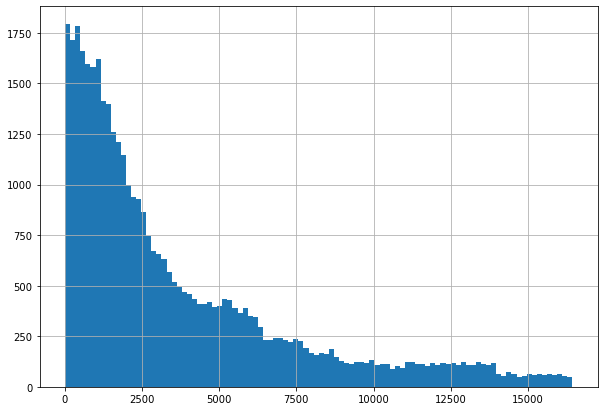

In [18]:
#построим распределение по рейтингу

plt.rcParams['figure.figsize'] = (10,7)
df['Ranking'].hist(bins=100)

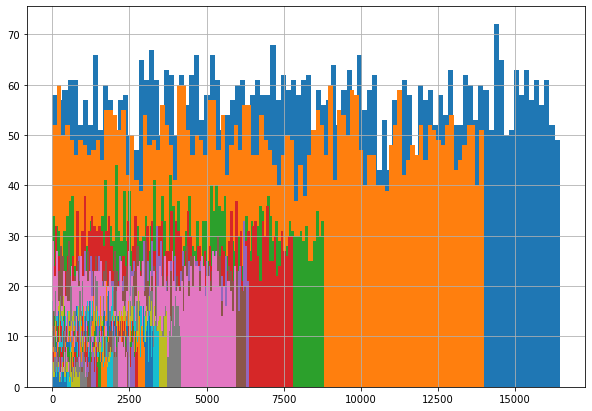

In [19]:
# Распределение получается по экспоненте. Странно. Оценим распределение по рейтингу в зависимости от города


for x in (df['City'].value_counts()).index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [20]:
# Итого имеем: много рестаранов в городе => тем больше разброс.
# Нормируем рейтинг на количество ресторанов в городе
rest_count = {}

for i in range(len(df['City'].value_counts().index)):
    rest_count[df['City'].value_counts().index[i]] = df['City'].value_counts()[
        df['City'].value_counts().index[i]]

for i in range(len(df)):
    df['Ranking'][i] = (df['Ranking'][i] / rest_count[(df['City'][i])])

/home/hotf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


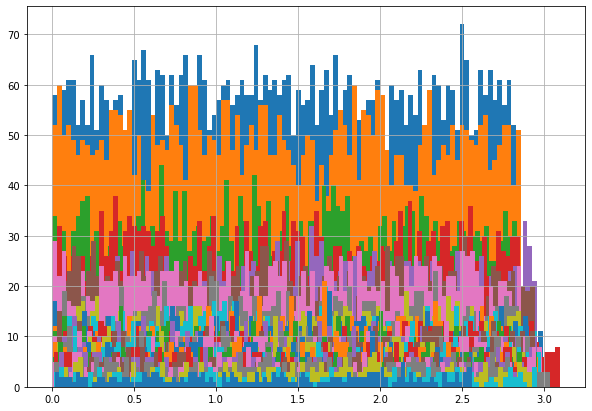

In [21]:
for x in (df['City'].value_counts()).index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

<AxesSubplot:>

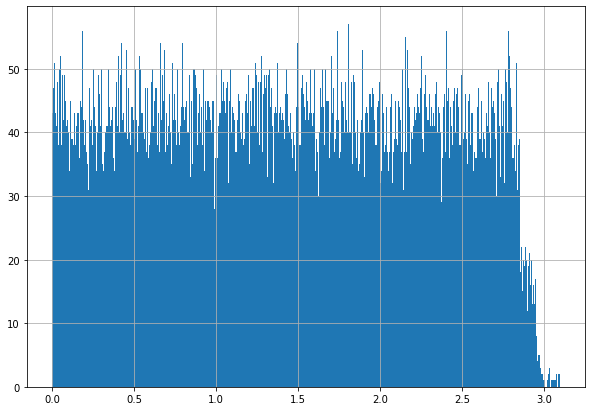

In [22]:
# Посмотрим как изменилось распределение:

plt.rcParams['figure.figsize'] = (10,7)
df['Ranking'].hist(bins=1000)

In [23]:
#Определенно лучше :)
#Вновь глянем на зависимость между велечинами 

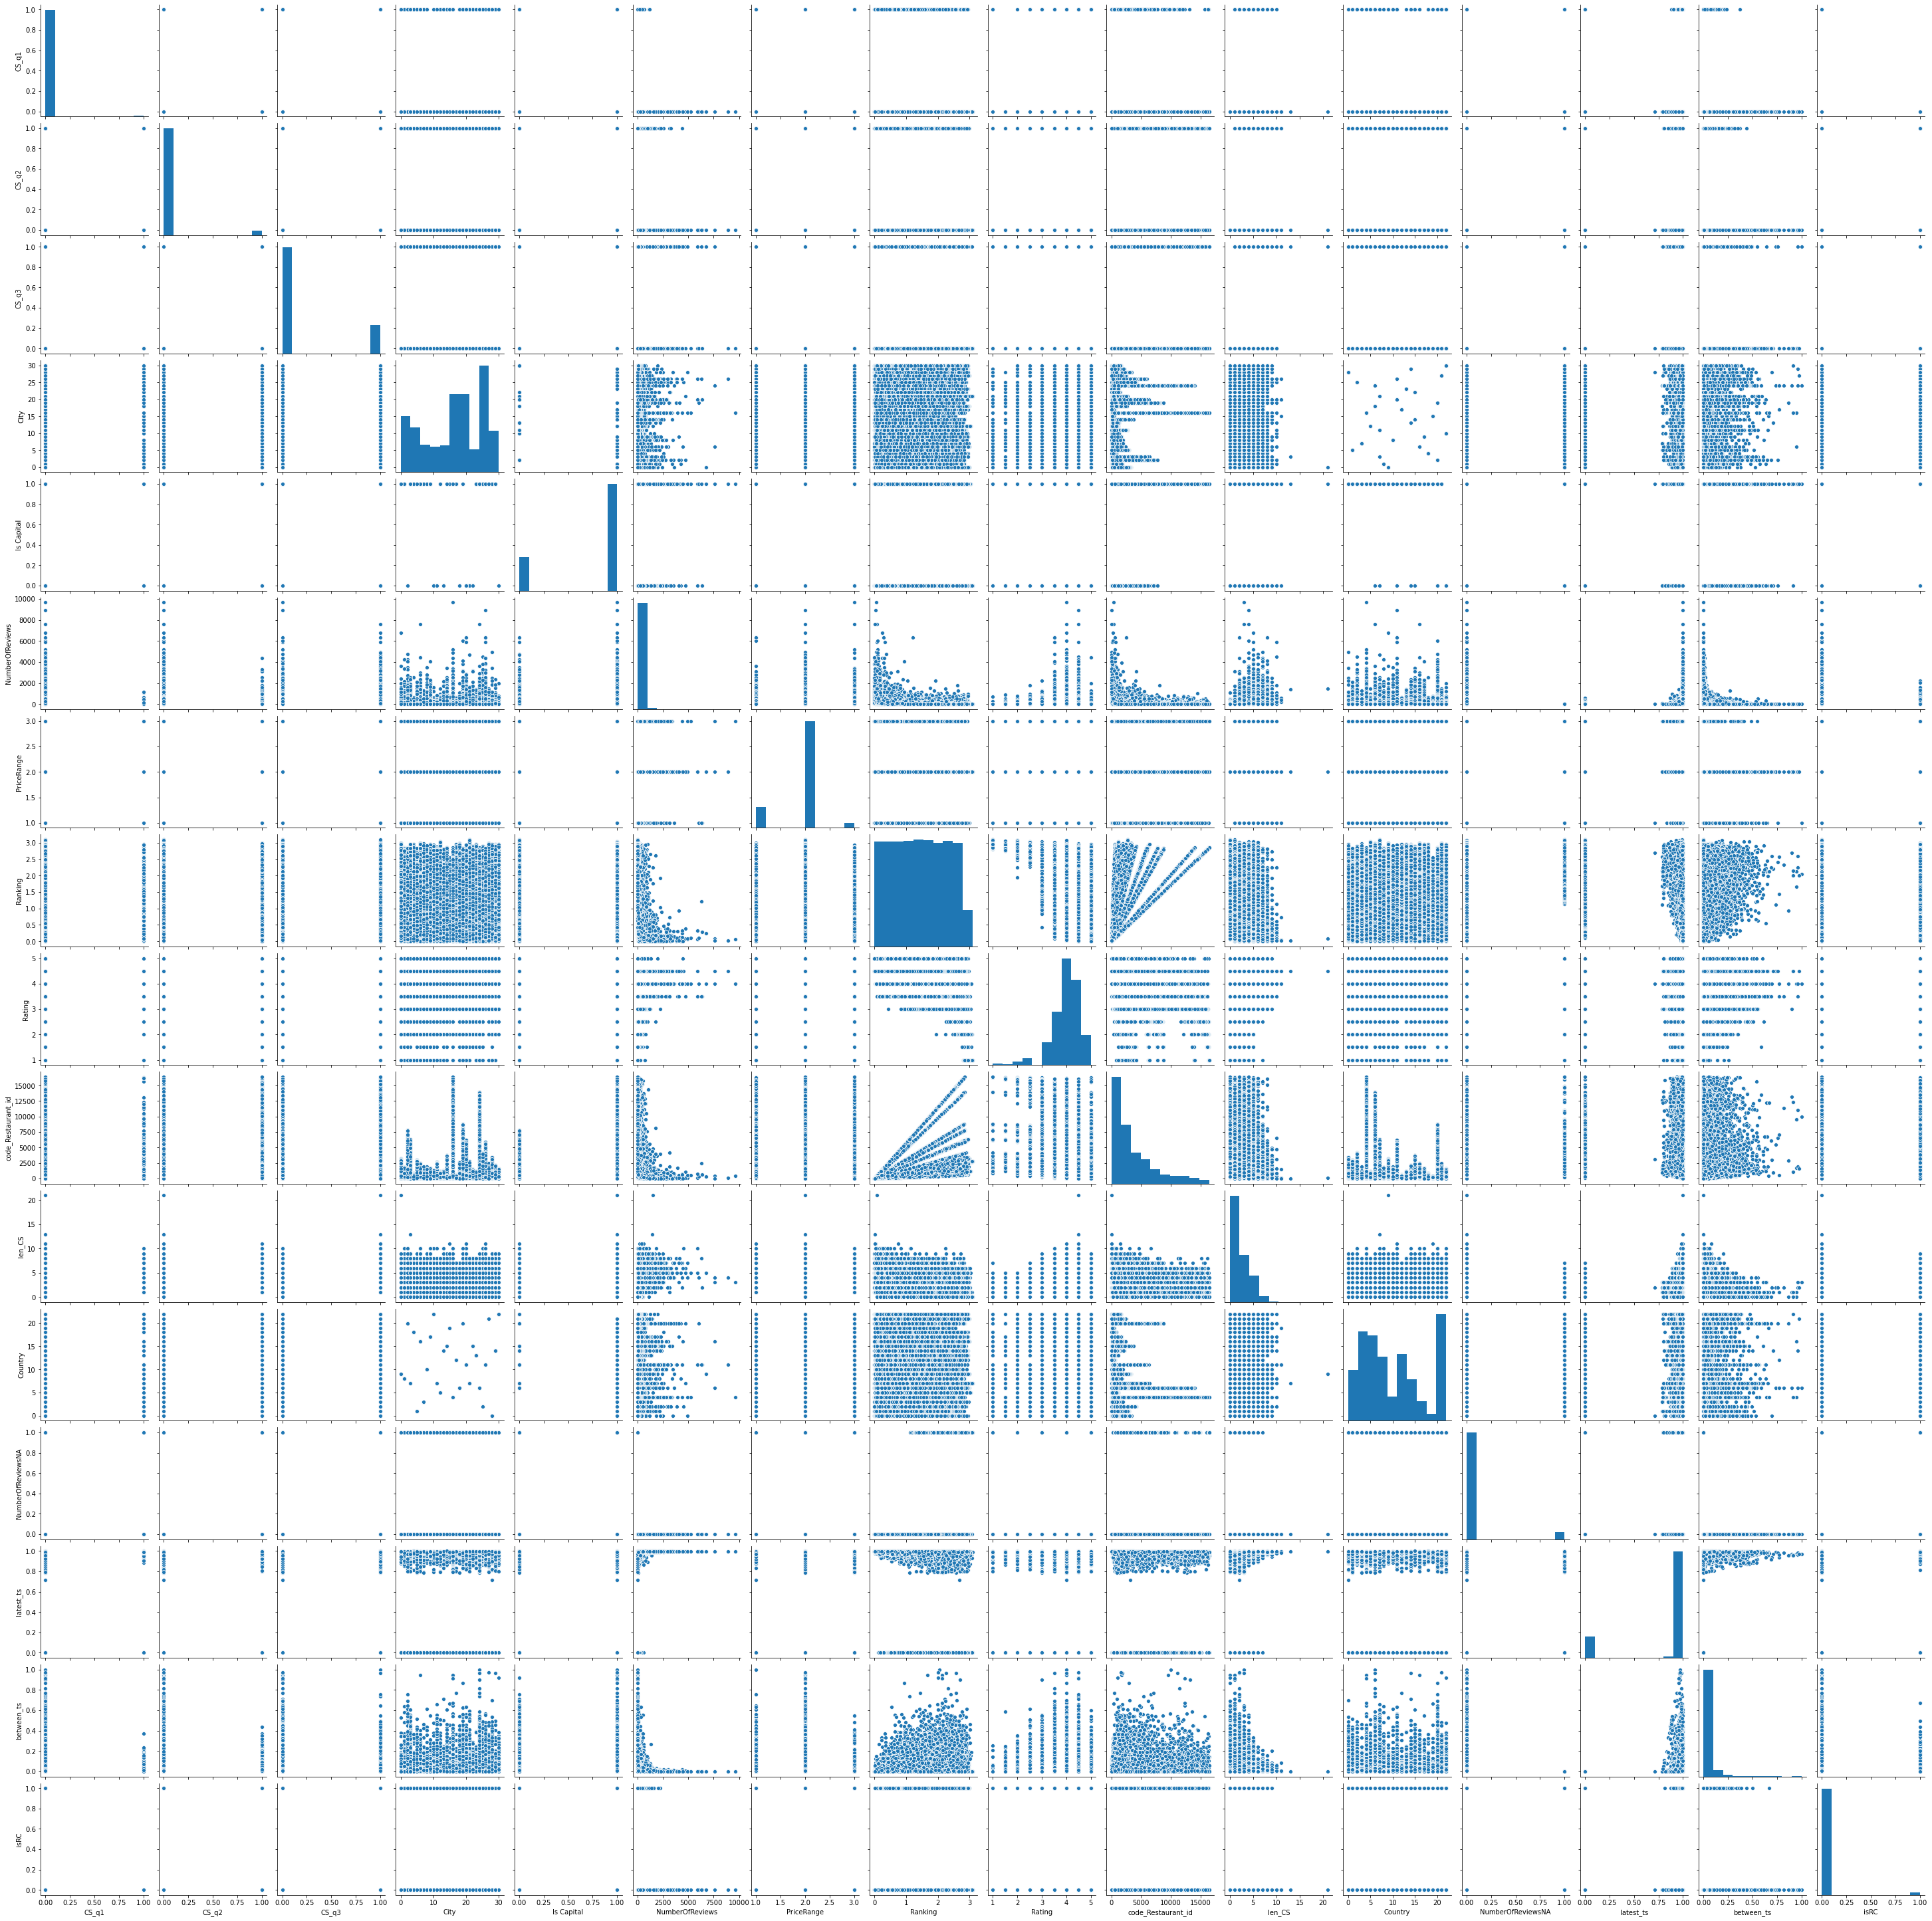

In [157]:
sns.pairplot(df.drop(['CS_q4'], axis=1))

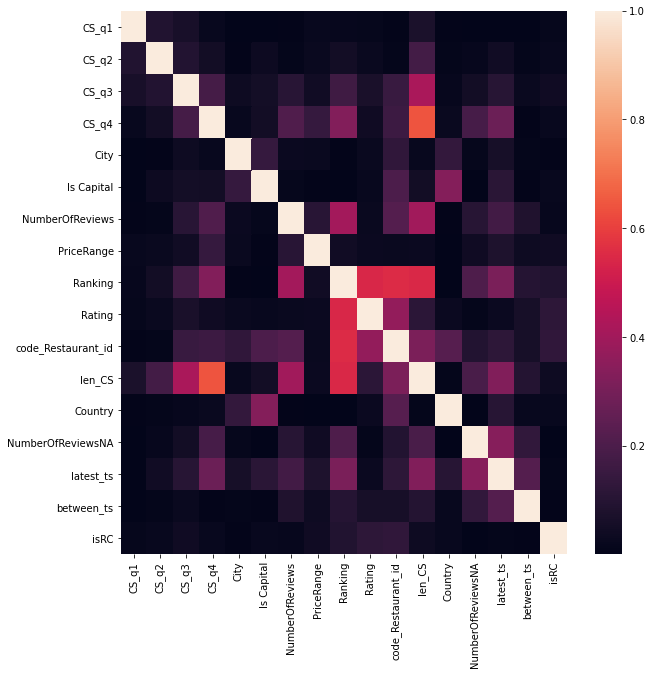

In [158]:
sns.heatmap(df.corr().abs());

In [80]:
df.head()

,CS_q1,CS_q2,CS_q3,CS_q4,City,CuisineStyle,ID_TA,Is Capital,NumberOfReviews,PriceRange,...,Reviews,URL_TA,code_Restaurant_id,len_CS,Сountry,NumberOfReviewsNA,latest_ts,between_ts,RestaurantChain,isRC
0,0,0,0,1,24,"[0, 1, 2]",d1912643,1,194.0,2,...,"[[good food at your doorstep, a good hotel res...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,5569.0,3.0,6,0,0.996759,0.012785,r_yves,0
1,0,0,0,0,27,[],d7992032,1,10.0,2,...,"[[unique cuisine, delicious nepalese food], [0...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,1535.0,0.0,21,0,0.986639,0.119114,buddha_nepal,0
2,0,0,1,1,16,"[3, 4, 5, 6, 7, 8, 9]",d8632781,1,688.0,3,...,"[[catch up with friends, not exceptional], [01...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,352.0,7.0,4,0,0.997214,0.000624,roka_mayfair,0
3,0,0,0,0,3,[],d1358776,1,3.0,2,...,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,3456.0,0.0,7,0,0.000000,0.000000,esplanade,0
4,0,0,0,1,21,"[10, 11, 7]",d6864963,0,84.0,2,...,"[[best place to try a bavarian food, nice buil...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,615.0,3.0,7,0,0.994314,0.084814,augustiner_schutzen_garten,0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CS_q1               40000 non-null  int64  
 1   CS_q2               40000 non-null  int64  
 2   CS_q3               40000 non-null  int64  
 3   CS_q4               40000 non-null  int64  
 4   City                40000 non-null  int64  
 5   CuisineStyle        40000 non-null  object 
 6   ID_TA               40000 non-null  object 
 7   Is Capital          40000 non-null  int64  
 8   NumberOfReviews     40000 non-null  float64
 9   PriceRange          40000 non-null  int64  
 10  Ranking             40000 non-null  float64
 11  Rating              40000 non-null  float64
 12  Restaurant_id       40000 non-null  object 
 13  Reviews             40000 non-null  object 
 14  URL_TA              40000 non-null  object 
 15  code_Restaurant_id  40000 non-null  float64
 16  len_

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [149]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'CuisineStyle', 'Rating', 'Reviews', 'Ranking', 'URL_TA', 'ID_TA', 'RT_meanlen', 'RT_meanHappy', 'RT_meanAngry', 'RT_meanSurprice', 'RT_meanSad', 'RT_meanFear'], axis = 1)
X = df.drop(['Restaurant_id', 'CuisineStyle', 'Rating', 'Reviews','latest_ts', 'URL_TA', 'ID_TA', 'RestaurantChain'], axis = 1)
y = df['Rating']

In [150]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CS_q1               40000 non-null  int64  
 1   CS_q2               40000 non-null  int64  
 2   CS_q3               40000 non-null  int64  
 3   CS_q4               40000 non-null  int64  
 4   City                40000 non-null  int64  
 5   Is Capital          40000 non-null  int64  
 6   NumberOfReviews     40000 non-null  float64
 7   PriceRange          40000 non-null  int64  
 8   Ranking             40000 non-null  float64
 9   code_Restaurant_id  40000 non-null  float64
 10  len_CS              40000 non-null  float64
 11  Сountry             40000 non-null  int64  
 12  NumberOfReviewsNA   40000 non-null  int64  
 13  between_ts          40000 non-null  float64
 14  isRC                40000 non-null  int64  
dtypes: float64(5), int64(10)
memory usage: 4.6 MB


In [151]:
C = X.corr(method='pearson')
C

,CS_q1,CS_q2,CS_q3,CS_q4,City,Is Capital,NumberOfReviews,PriceRange,Ranking,code_Restaurant_id,len_CS,Сountry,NumberOfReviewsNA,between_ts,isRC
CS_q1,1.000000,0.086682,0.063280,0.020205,-0.004108,-0.001497,-0.007340,-0.023726,-0.016401,-0.006475,0.071292,-0.004989,-0.002485,-0.004320,-0.013260
CS_q2,0.086682,1.000000,0.092112,0.048461,-0.004666,0.034342,0.009106,-0.024956,-0.051079,-0.009933,0.179909,-0.011387,-0.016239,-0.011566,-0.023091
CS_q3,0.063280,0.092112,1.000000,0.183991,-0.036092,0.051813,0.108300,-0.044460,-0.167452,-0.151846,0.418734,-0.018694,-0.049371,-0.026963,-0.041344
CS_q4,0.020205,0.048461,0.183991,1.000000,0.022599,0.048393,0.209360,-0.142201,-0.331617,-0.156769,0.643324,-0.027447,-0.187655,0.007607,-0.022574
City,-0.004108,-0.004666,-0.036092,0.022599,1.000000,0.143849,0.030544,0.025366,-0.007986,0.126669,-0.023806,-0.135047,-0.014985,0.008514,0.004473
Is Capital,-0.001497,0.034342,0.051813,0.048393,0.143849,1.000000,0.013466,-0.008270,-0.003373,0.202283,0.049109,-0.332559,0.001391,-0.006280,0.021254
NumberOfReviews,-0.007340,0.009106,0.108300,0.209360,0.030544,0.013466,1.000000,0.107162,-0.406344,-0.222036,0.399564,0.007807,-0.105853,-0.083595,-0.016855
PriceRange,-0.023726,-0.024956,-0.044460,-0.142201,0.025366,-0.008270,0.107162,1.000000,-0.046487,-0.026516,-0.029666,-0.000551,0.040268,-0.038451,-0.041435
Ranking,-0.016401,-0.051079,-0.167452,-0.331617,-0.007986,-0.003373,-0.406344,-0.046487,1.000000,0.553090,-0.543494,-0.000683,0.207244,0.099057,0.088423
code_Restaurant_id,-0.006475,-0.009933,-0.151846,-0.156769,0.126669,0.202283,-0.222036,-0.026516,0.553090,1.000000,-0.313226,-0.225489,0.094039,0.059510,0.125636


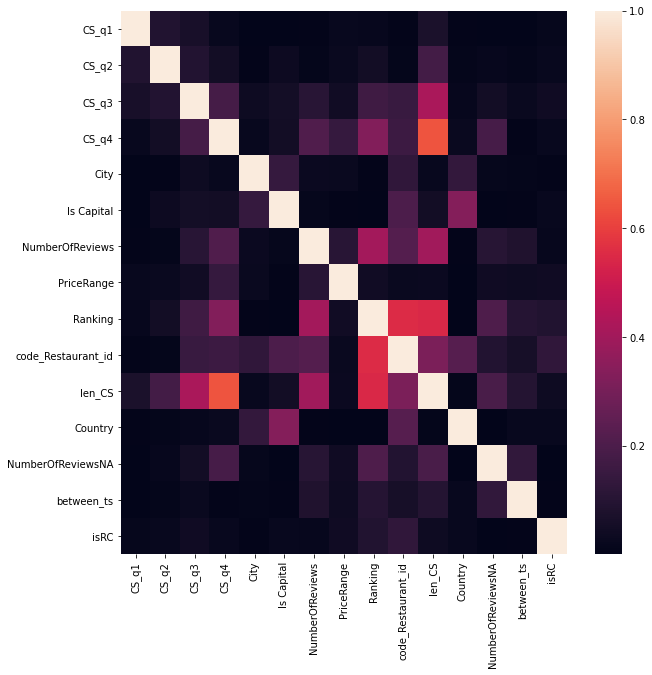

In [152]:
sns.heatmap(X.corr().abs());

In [153]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [154]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.1s finished


<AxesSubplot:>

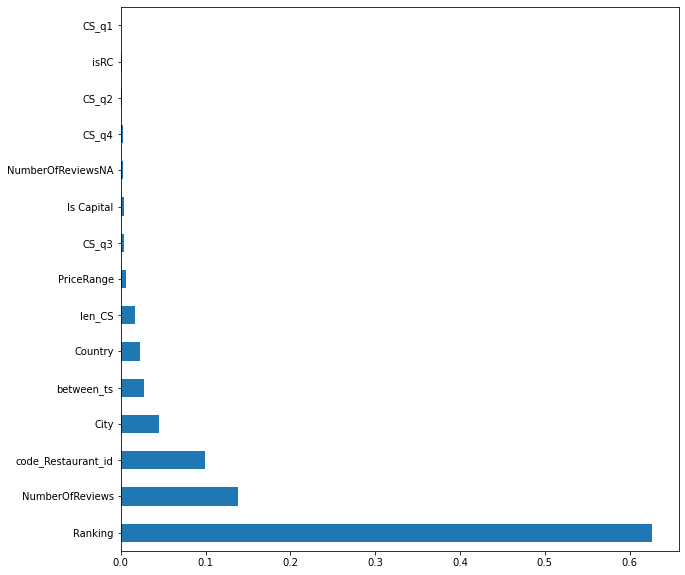

In [155]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [156]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20817624999999998


In [147]:
# функция округления результатов предсказания
def round_pred(y_pred):
    return [(round(y / 0.5) * 0.5) for y in y_pred]

In [148]:
y_pred_rnd = round_pred(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rnd))

MAE: 0.1793125
